[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis-nlp/tutorial-nlp-notebooks/blob/main/rnn_language_model.ipynb)

In [ ]:
data = 'Chios island is crescent or kidney shaped, 50 km (31 mi) long from north to south, and 29 km (18 mi) at its widest, covering an area of 842.289 km2 (325.210 sq mi).[2] The terrain is mountainous and arid, with a ridge of mountains running the length of the island. The two largest of these mountains, Pelineon (1,297 m (4,255 ft)) and Epos (1,188 m (3,898 ft)), are situated in the north of the island. The center of the island is divided between east and west by a range of smaller peaks, known as Provatas.'


In [ ]:
# see here for notation http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture10.pdf
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
#data = open('input.txt', 'r').read() # should be simple plain text file - you can use any (small) file in txt format from the web or type your own. 

chars = list(set(data))                              # list : one instance of each char in data
data_size, vocab_size = len(data), len(chars)        # int : number of characters | int number of distinc chars
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }   # dict : char : number off occurences
ix_to_char = { i:ch for i,ch in enumerate(chars) }   # dict : number of occurences : char

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden     hiden_size by vocab matrix of random numbers
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden   hiden_size by hiden_size matrix of random numbers 
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output    
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias


data has 508 characters, 43 unique.


In [ ]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  h 
  seed_ix
  n int: length of the sample

  return ixes: list of integer indexes of character predictions
  """
  x = np.zeros((vocab_size, 1))         # vocab_size x 1 matrix of 0
  x[seed_ix] = 1                        # replace x at seed_x with 1
  ixes = []                             # an empty list 
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)      # hidden neurons
    y = np.dot(Why, h) + by                                # prediction
    p = np.exp(y) / np.sum(np.exp(y))                      # predicted probabilities of each character
    ix = np.random.choice(range(vocab_size), p=p.ravel())   # non uniform random sample of indexes from number of characters
    x = np.zeros((vocab_size, 1))
    x[ix] = 1                                              # one hot encoding for what the next character is
    ixes.append(ix)
  return ixes                           # an n sized list of vocab_size sized vectors
                                        # TODO each vector 

In [ ]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  inputs list of int: 
  targets list of int: 
  hprev array: previous hidden state
  """

  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]




In [17]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]              # indexes of the 25 input characters in this interation
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]         # indexes of 25 target characters for this iteration
  """
    sweep through the data left to right, when you reach the end go back to the start
    when you return to start, reset hprev (hidden state) to zeros
  """

  # sample from the model now and then
  if n % 1000 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)                    # model prediction at this time iteration

    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 1000 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter

  if n > 10000:
    break 

----
 hios islandivided betweeThen cent ar as and Epos (1,18 (the aerlen as d is covering an aidn of 842.289. aks, known raller idgeon (1,297 m (4,255 ft)), areritwind length oi).[2] The uvidng, a ris llong 
----
iter 0, loss: 93.938544
----
 hio ti) th 5 9 km ound mor int sthes5ithe f by.29251 qt of ns km0 o (18 is,eigd kme the t) tant of nd apre55g b or (31 ThefenerThe intlaisland., o in erin si)l Theshe e tes (1898 (1,29) pendelpeounth  
----
iter 1000, loss: 66.386395
----
 hios isa m istarin ridietranli)he sed (4,eund 29 aind ism ath tunto5 akanof mi) or (325.2rand annd ang of tnd mount by  m o m (4,2.[2] omi)hankmo scendeand ofkmkmiige 84 aind 84argess, of mounteat, an 
----
iter 2000, loss: 40.301854
----
 hios isast s (19897 mi) lar (3,9 wee ft))rand 29Theridge as.h the ing th of mountheh laere0 mi) lon an misllidlensland. The sountof mi) lonen coveoun nof scenthe island. 50 kmivid wfbe arges cre k asw 
----
iter 3000, loss: 25.604527
----
 hios i)lan sg t of th the smaldes len

# 1. Unfortunately the author didnt insert any explanations or comments so we ask you to explain what the model seems to be doing, the model components that include parameters, losses, dimensions of the tensors etc.  (10 points)


**The model components**

number of hidden neurons n = hidden_size (set to 100)
number of distinc character c = vocab_size

*Parameters*
 - depth of the hidden layer (number of neurons)
 - step size
 - weights
  - wxh (input to hidden)
  - whh (hidden to hidden)
  - why (hidden to ouput)

*Losses*
 - Cross entropy loss function
 - softmax
 - Smoothing
  - regularization tecnique that addresses overfitting and overconfidence[1]
  - $sl_{t} = sl_{t-1}* 0.999 + CE * 0.001$

*Dimension of the tensors*

Wxh (input to hidden)
 - n x c matrix

Whh (hidden to hidden) 
 - n x n matrix

Why (hidden to output)
 - c x n matrix   

bh (hidden bias)
 - n x 1 vector

by (output bias)
 - c x 1 vector

**What is the model doing**

 - The model processes the the characters of the input in groups of size sequence_length (set to 25)

 - It uses tanh as an the activation function

 - It stores the memory of the previous iterations in mWxh, mWhh, mWhy, mbh, mby. These are all initalized at 0. 

 - It calculates the gradients for each parameter in dWxh, dWhh, dWhy, dbh, dby.

 - Carries out SGD using Adagrad (Adaptive Gradient) to train the model. This means it adapts an individual learning rate for each feature. The features that occur less frequence have a higher learning rate. Lower gridents produce lower step sizes to promote convergence to the minimum.[2] 
   - $parameter_{t}=paramter_{t-1}-η*\frac{ gradient_{parameter}}{\sqrt{gradient^{T}gradient + 1e-8} }$
 - The model learns the probability distribution of what the next character will be given the previous characters and chooses the most likely next character



[1]: https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06
[2]: https://optimization.cbe.cornell.edu/index.php?title=AdaGrad



# 2. Insert the back-propagation equations in the corresponding section of the simple RNN model code  - you can do that using markdown and latex or hand write and insert png images in the notebook (10 points)

## Forwared Pass

xs = hot encoded vector (vocab_size x 1)

1) $hs_t = tanh[(xs * Wxh) + (hs_{t-1} * Whh)]$  (hidden state)

2) $ys = (Why * hs) + by$

3) $ps = exp(\frac{ys_t}{∑exp(ys_t)})$

4) $L = -log(s)$
 - let s = softmax(ps)



## Backward Pass

$\frac{dL}{dL} = 1$

4)  $ds = dL * \frac{d}{ds}(-log(s)$

$ds = \frac{-1}{s}$

3) $dps = ds * \frac{d}{ps}(softmax(ps))$

2) $dy_t = ds * \frac{d}{dy}((\frac{exp(ys)}{∑ exp(ys)}))$

1) $dh_t = \frac{d}{dh_t}((Why * hs) + by))$
 - since by is a constant $\frac{d}{dy}(by) = 0$
 - $\frac{d}{dx}(x dot y) = y^T$

$ dh_t = dy * Why^T$
 - this will flow back in time through the tanh gate, and sum and dot product gate

$dh_{t-2} = dy * Why^T * \frac{d}{dh_{t-2}}(tanh[(xs * Wxh) + (hs_{t-1} * Whh)])$




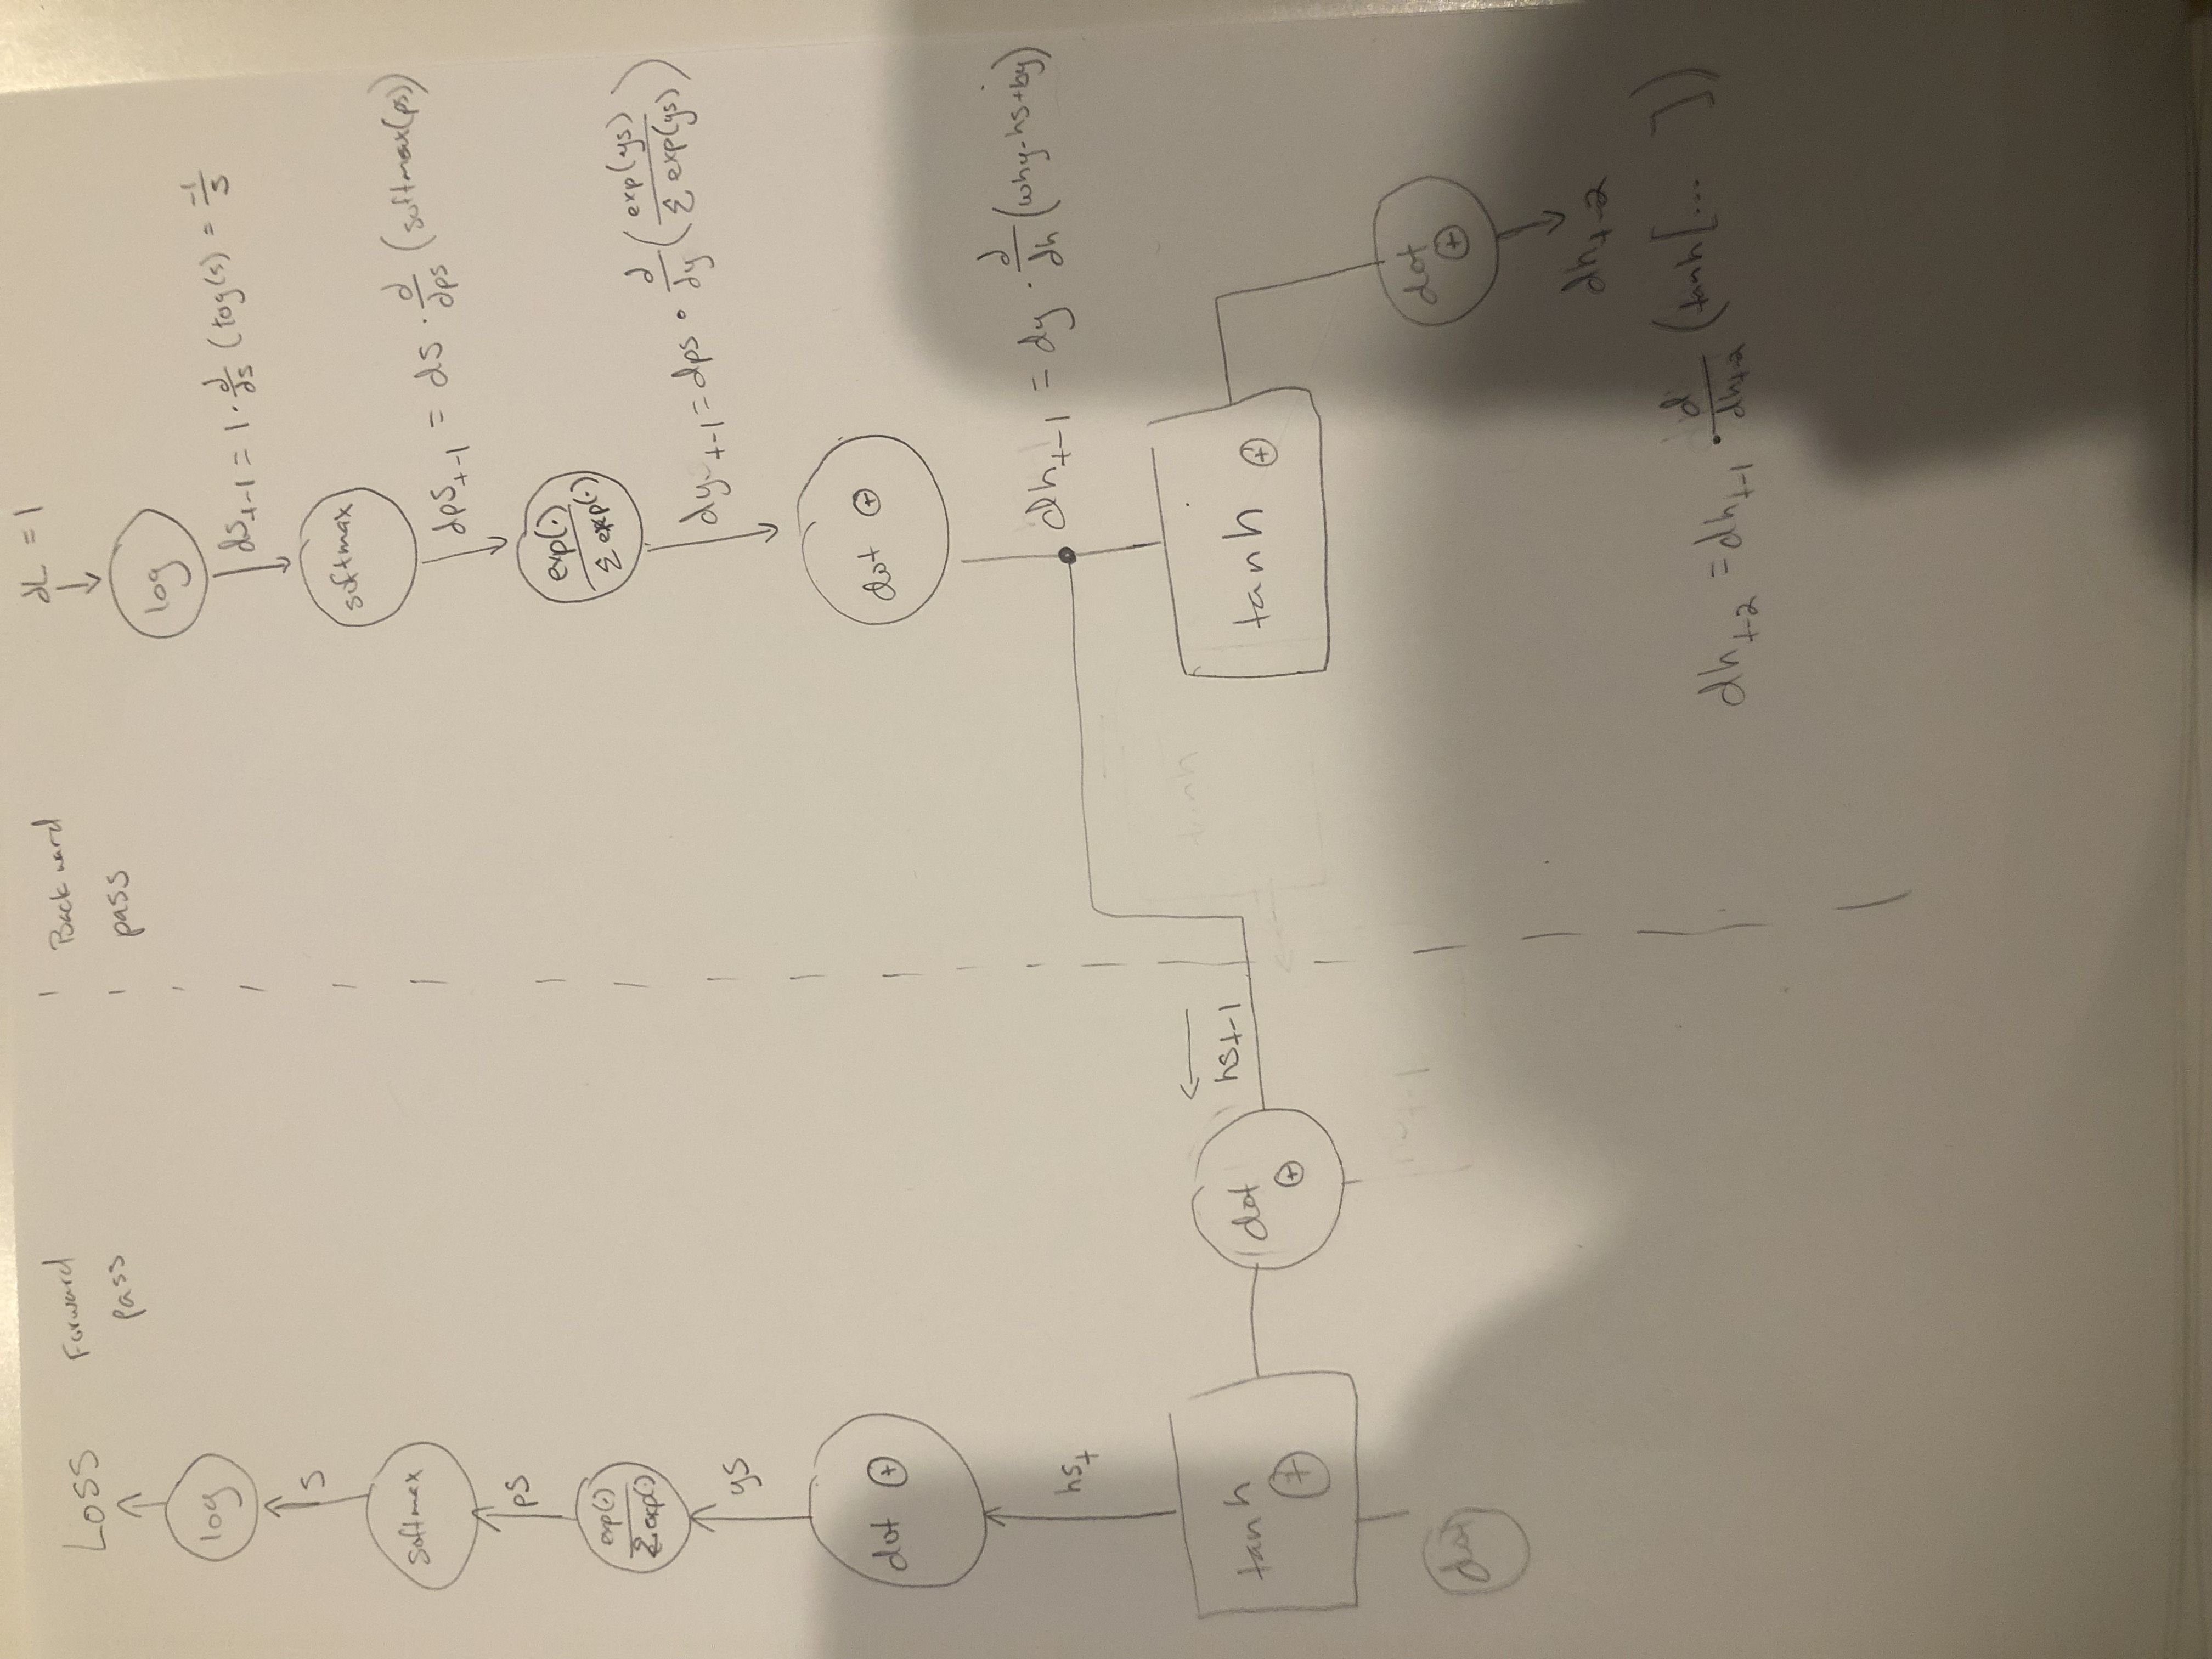

# 3. Implement from scratch the same functionality using a CNN, determining its architecture, all its dimensions. Insert comments for each line you implement. The network should produce the same output over time as the RNN implementation above  (20 points)  

* We advise you to use the JAX version of numpy but its up to you.